In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from IPython.display import display
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mean_squared_error as mse, hamming_loss
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [58]:
%matplotlib widget

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = 'silver'

In [59]:
def interval_loss(y_true, y_pred, offset=1):
    """
    Calculeaza proportia de y_pred care nu deviaza mai mult de +/- offset fata de y_true
    """
    nr_in_interval = np.abs(y_true - y_pred) < offset
    return nr_in_interval.mean()

# Decision stumps

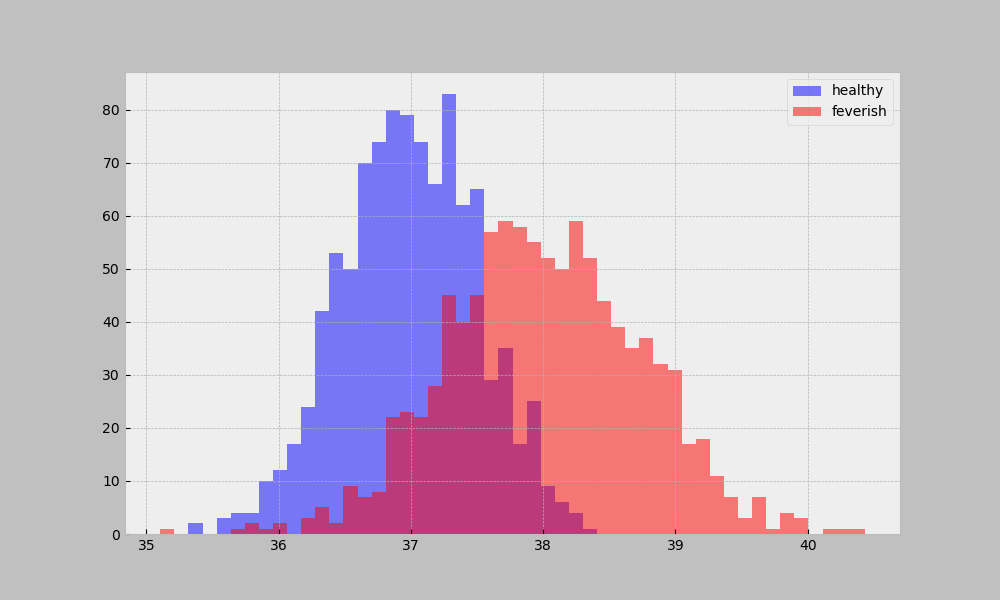

In [60]:
healthy_temp = norm(loc=37, scale=.5).rvs(size=1000)
fever_temp = norm(loc=38, scale=.75).rvs(size=1000)
temps = np.concatenate([healthy_temp, fever_temp])
has_fever = np.concatenate([np.zeros_like(healthy_temp), np.ones_like(fever_temp)])

plt.hist(healthy_temp, label='healthy', bins=50, range=(temps.min(), temps.max()), color='b', alpha=.5)
plt.hist(fever_temp, label='feverish', bins=50, range=(temps.min(), temps.max()), color='r', alpha=.5)
plt.legend()

In [61]:
def gini_impurity(labels):
    """
    The Gini impurity is the probability of selecting two instances with different labels
    from the distribution
    """
    _, frequencies = np.unique(labels, return_counts=True)
    frequencies = frequencies / frequencies.sum()
    return 1 - np.sum(frequencies ** 2)

impurities = []
for value in np.sort(temps)[:-1]:
    mask = temps <= value
    gl = gini_impurity(has_fever[mask])
    gr = gini_impurity(has_fever[~mask])
    impurities.append(gl * np.mean(mask) + gr * np.mean(~mask))

plt.plot(np.sort(temps)[:-1], impurities)

idx = np.argmin(impurities)
split_value = np.sort(temps)[idx]
print(f'Splitting by body temperature of {split_value:.1f}C, averages on {impurities[idx]:.2%} chance of mislabeling')

Splitting by body temperature of 37.6C, averages on 30.94% chance of mislabeling


[877 266] [123 734]


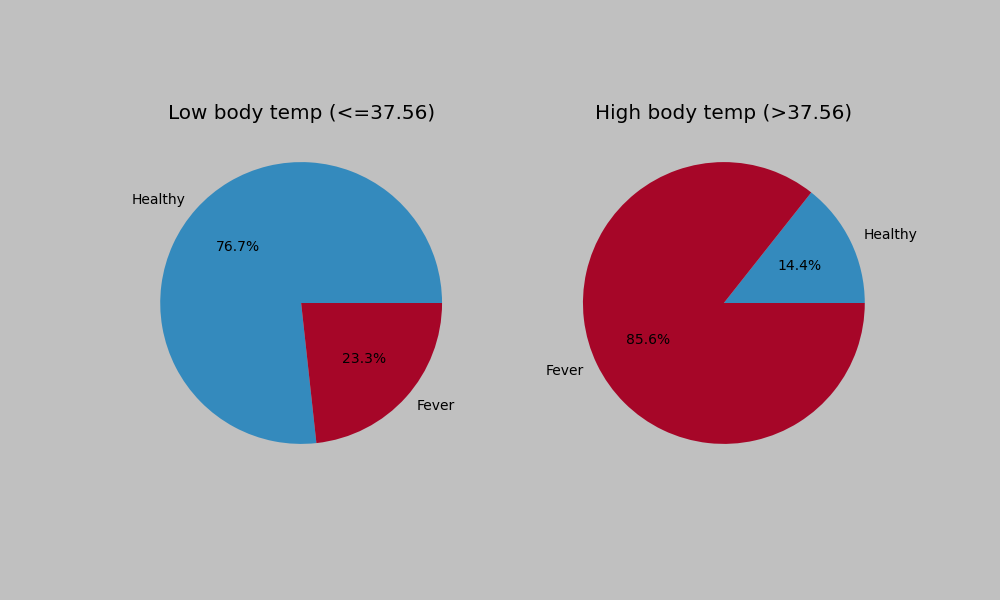

In [62]:
_, lo_temp = np.unique(has_fever[temps <=split_value], return_counts=True)
_, hi_temp = np.unique(has_fever[temps > split_value], return_counts=True)
print(lo_temp, hi_temp)

fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.set_title(f'Low body temp (<={split_value:.2f})')
ax1.set_title(f'High body temp (>{split_value:.2f})')
ax0.pie(lo_temp, labels=['Healthy', 'Fever'], autopct='%1.1f%%')
ax1.pie(hi_temp, labels=['Healthy', 'Fever'], autopct='%1.1f%%');

In [63]:
fh = norm(loc=1.65, scale=.07).rvs(size=1000)
mh = norm(loc=1.72, scale=.09).rvs(size=1000)

fw = 22 * fh ** 2 + norm(scale=2).rvs(size=1000)
mw = 27 * mh ** 2 + norm(scale=4).rvs(size=1000)

df = pd.DataFrame({'height': np.concatenate([fh, mh]), 'weight': np.concatenate([fw, mw]), 
                   'gender': 1000 * ['F'] + 1000 * ['M']})
display(df)

sns.scatterplot(x='weight', y='height', hue='gender', data=df, alpha=.25)

,height,weight,gender
0,1.717109,65.216675,F
1,1.678589,62.149429,F
2,1.569919,48.634609,F
3,1.591010,53.528907,F
4,1.544312,52.525728,F
...,...,...,...
1995,1.797027,88.409871,M
1996,1.758853,89.723514,M
1997,1.737239,88.919897,M
1998,1.707677,73.674125,M


<AxesSubplot:title={'center':'High body temp (>37.56)'}, xlabel='weight', ylabel='height'>

Loss function we are trying to minimize where **L** and **R** are the instances whose feature value falls below/above a threshold:

$\Large \frac{\sum\limits_{i \in L} (y_i - \mu_L) ^ 2 + \sum\limits_{i \in R}{(y_i - \mu_R) ^ 2}}{N}$

The point is to find a feature and a threshold based on which each instance can be assigned a better mean value for **y**.

In [64]:
# Operatiile de pandas care suporta `inplace` nu vor returna nimic cand inplace=True
# Cand inplace=False (default), returneaza o copie asupra careia s-a aplicat modificarea

# df = df.sort_values(by='weight')
df.sort_values(by='weight', inplace=True)

vl, vr = [], []
for w in df['weight']:
    hl = df[df['weight'] <= w]['height'] 
    hr = df[df['weight'] >  w]['height']
    
    vl.append(sum((hl - hl.mean()) ** 2) / len(df))
    vr.append(sum((hr - hr.mean()) ** 2) / len(df))

df = df.assign(height_sqdev_l = vl, height_sqdev_r = vr)

# Merge mai bine asa, dar e mai neclar cum functioneaza
# hl = df['height'].expanding()
# hr = df[::-1]['height'].expanding()
# df = df.assign(height_sqdev_l = hl.var() * hl.count() / len(df),
#                height_sqdev_r = hr.var() * hr.count() / len(df))

plt.plot(df.weight, df.height_sqdev_l)
plt.plot(df.weight, df.height_sqdev_r)
plt.plot(df.weight, df.height_sqdev_l + df.height_sqdev_r);

# Decision Trees

[Pentru mai multe dataseturi](https://scikit-learn.org/stable/datasets/index.html)

In [65]:
from sklearn.datasets import fetch_california_housing, load_breast_cancer
# boston = load_boston() # Deprecated
california = fetch_california_housing()
breast_cancer = load_breast_cancer()

X = pd.DataFrame(california['data'], columns=california['feature_names'])
y = california['target']

display(X)
print(california['DESCR'])

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [66]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [67]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.25, random_state=2022)
model = DecisionTreeRegressor()
model.fit(X_trn, y_trn)

print(f'Train: {mse(y_trn, model.predict(X_trn))}')
print(f'Validation: {mse(y_val, model.predict(X_val))}')

Train: 8.1586970882354e-32
Validation: 0.5528655217365503


In [68]:
model.score(X_trn, y_trn), model.score(X_val, y_val)

(1.0, 0.5776516834044618)

In [69]:
models, trn_scores, val_scores = [], [], []
for d in tqdm(range(1, model.get_depth() + 1)):
    m = DecisionTreeRegressor(max_depth=d)
    m.fit(X_trn, y_trn)
    
    trn_scores.append(mse(y_trn, m.predict(X_trn)))
    val_scores.append(mse(y_val, m.predict(X_val)))
    models.append(m)

  0%|          | 0/39 [00:00<?, ?it/s]

In [70]:
plt.plot(np.arange(model.get_depth()) + 1, trn_scores, label='Train')
plt.plot(np.arange(model.get_depth()) + 1, val_scores, label="Validation")
plt.gca().set_xlabel('Max depth')
plt.gca().set_ylabel('Mean squared error')
plt.legend();

In [71]:
plt.plot(np.arange(model.get_depth()) + 1, [m.score(X_trn, y_trn) for m in models], label='Train')
plt.plot(np.arange(model.get_depth()) + 1, [m.score(X_val, y_val) for m in models], label='Validation')
plt.gca().set_xlabel('Max depth')
plt.gca().set_ylabel('$R^2$ coefficient')
plt.legend();

In [72]:
%conda install graphviz -y 
%conda install -c conda-forge pydotplus -y

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


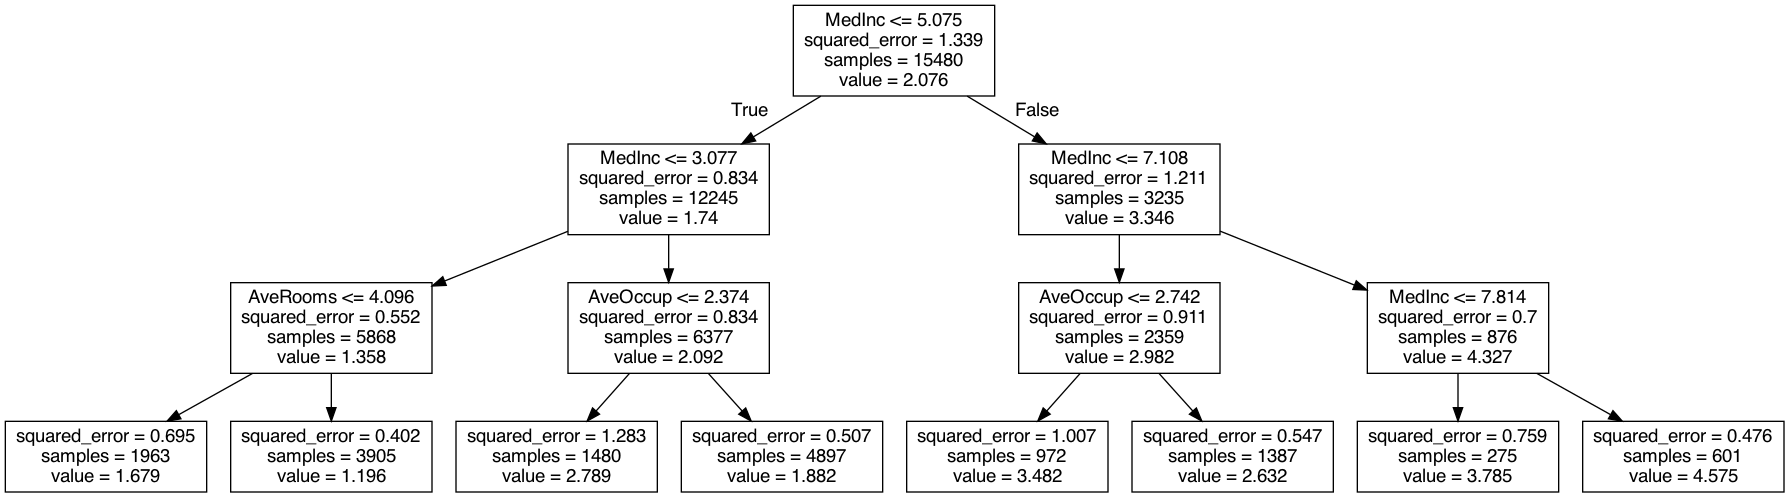

In [73]:
from IPython.display import Image
from sklearn.tree import export_graphviz

export_graphviz(models[3-1], feature_names=california['feature_names'], out_file='./tree.dot')
!dot -Tpng tree.dot -o tree.png

Image('./tree.png')

# Random Forests

In [74]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [75]:
rf = RandomForestRegressor(oob_score=True, max_depth=10)
rf.fit(X_trn, y_trn)

print(f'Train: {rf.score(X_trn, y_trn)}')
print(f'Validation: {rf.score(X_val, y_val)}')
print(f'OOB: {rf.oob_score_}')

Train: 0.8714278226208854
Validation: 0.7724737239313435
OOB: 0.7789674968531844


In [76]:
trn, val, oob = [], [], []
for n in tqdm(1 + np.arange(40)):
    rf = RandomForestRegressor(n_estimators=n)
    rf.fit(X_trn, y_trn)
    
    trn.append(rf.score(X_trn, y_trn))
    val.append(rf.score(X_val, y_val))
    
plt.plot(1 + np.arange(40), trn, label='Train')
plt.plot(1 + np.arange(40), val, label='Validation')
plt.gca().set_xlabel('# estimators')
plt.gca().set_ylabel('$R^2$ coefficient')
plt.legend();

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

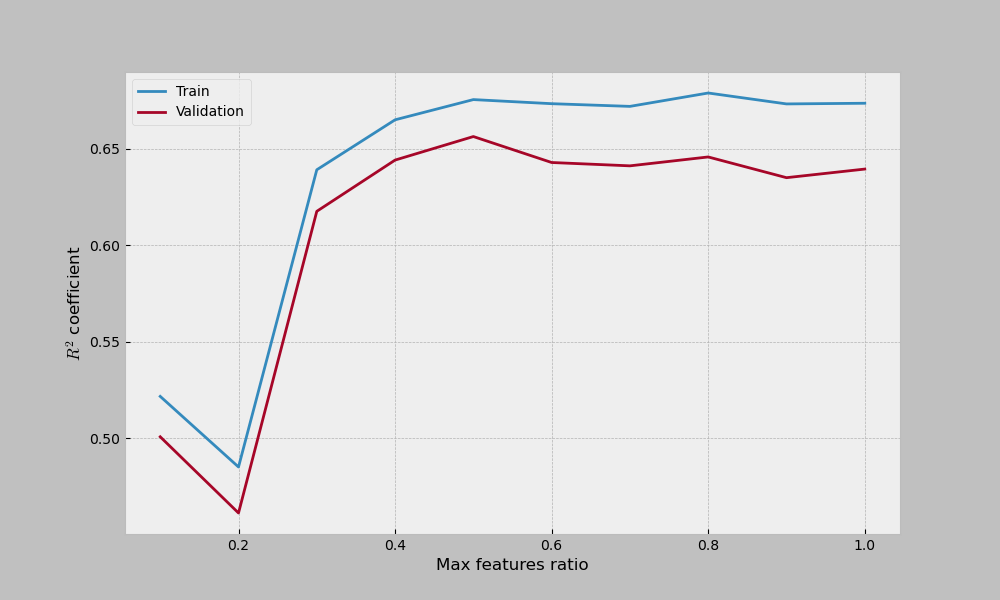

In [85]:
%matplotlib widget
trn, val = [], []
for mf in tqdm((1 + np.arange(10)) / 10):
    rf = RandomForestRegressor(n_estimators=10, max_features=mf, max_depth=5)
    rf.fit(X_trn, y_trn)
    
    trn.append(rf.score(X_trn, y_trn))
    val.append(rf.score(X_val, y_val))
    
plt.plot((1 + np.arange(10)) / 10, trn, label='Train')
plt.plot((1 + np.arange(10)) / 10, val, label='Validation')
plt.gca().set_xlabel('Max features ratio')
plt.gca().set_ylabel('$R^2$ coefficient')
plt.legend();

<AxesSubplot:xlabel='Max features ratio', ylabel='$R^2$ coefficient'>

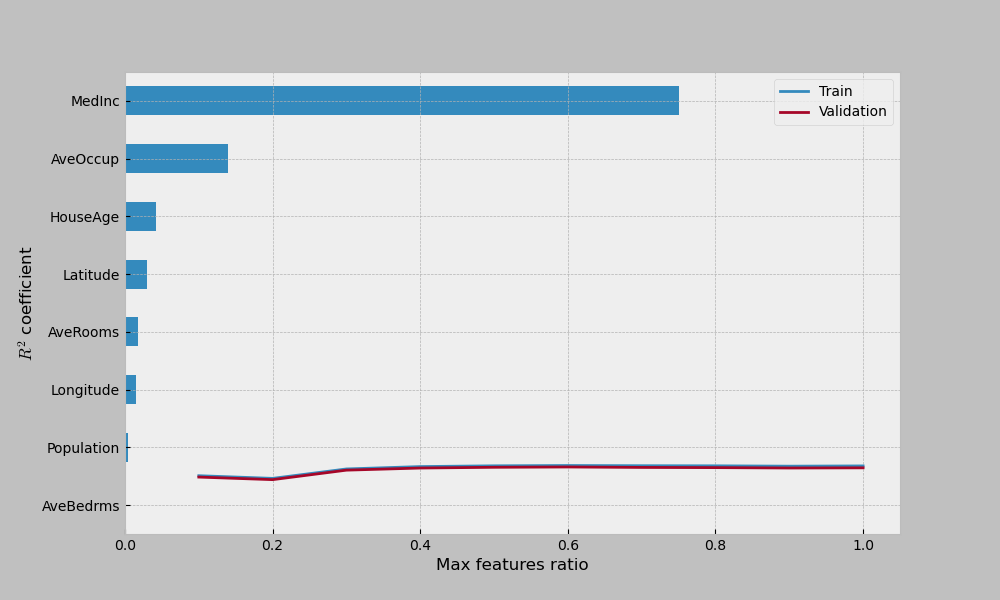

In [78]:
pd.Series(rf.feature_importances_, index=california['feature_names']).sort_values().plot.barh()

In [79]:
ax = sns.scatterplot(x='MedInc', y='AveOccup', hue='Price', data=X.assign(Price=y), palette='viridis', s=25, ec=None, lw=0)
ax.set_yscale('log')
ax.set_ylim(top=15)

/var/folders/9v/c16ht93j5zndjmhbp9pcxzqr0000gn/T/ipykernel_8846/3716275759.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(top=15)


(0.25, 15)

In [80]:
ax = sns.scatterplot(x='Longitude', y='Latitude', hue='Price', data=X.assign(Price=y), palette='viridis', s=25, ec=None, lw=0)
ax.set_aspect('equal')

# K nearest neighbors

In [81]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

knn_models = []
trn, val = [], []
for k in tqdm(range(1, 50)):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_trn, y_trn)
    knn_models.append(knn)
    
    trn.append(knn.score(X_trn, y_trn))
    val.append(knn.score(X_val, y_val))

  0%|          | 0/49 [00:00<?, ?it/s]

In [82]:
plt.plot([knn.n_neighbors for knn in knn_models], trn, label='Train')
plt.plot([knn.n_neighbors for knn in knn_models], val, label='Validation')
plt.legend()

  0%|          | 0/4 [00:00<?, ?it/s]

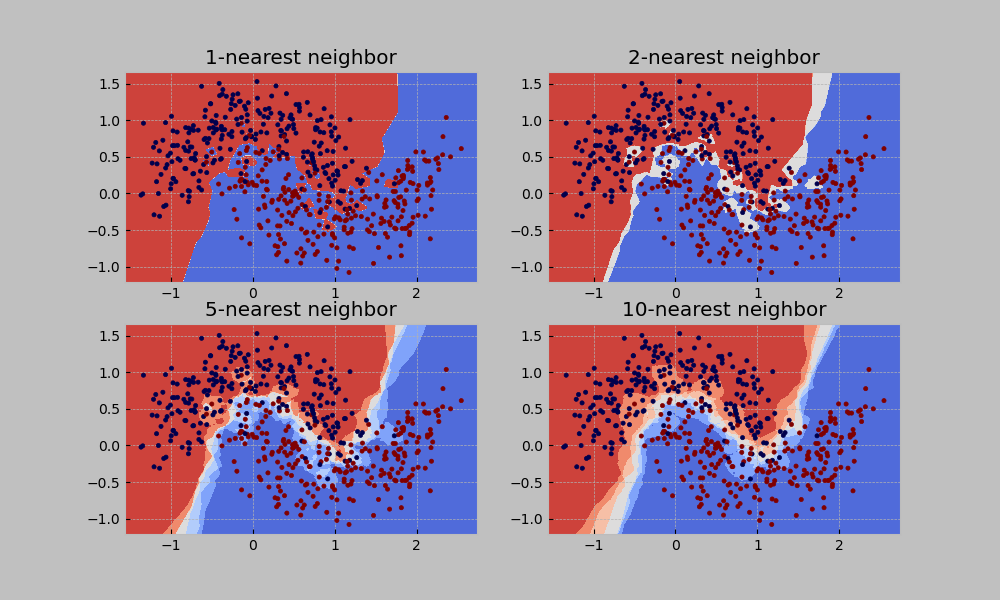

In [83]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(500, noise=.25)

fig, axs = plt.subplots(nrows=2, ncols=2)
for i, k in enumerate(tqdm([1, 2, 5, 10])):
    axs.flat[i].scatter(*X_moons.T, c=y_moons, cmap='seismic', marker='.', zorder=10)
    axs.flat[i].set_title(f'{k}-nearest neighbor')
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_moons, y_moons)
    
    xx, yy = np.meshgrid(np.linspace(*axs.flat[i].get_xlim(), 1000), 
                         np.linspace(*axs.flat[i].get_ylim(), 1000))

    z = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    axs.flat[i].contourf(xx, yy, z[:, 0].reshape(xx.shape), cmap='coolwarm')

Pentru ca opereaza pe distante intre puncte de date, KNN e sensibil la diferenta de dispersie de la un feature la altul.
De exemplu, distanta de la un individ de 20 de ani cu inaltimea 1.85m la unul de 40 de ani de 1.65m va fi dominata de varsta.

$(20-40)^2$ e mult mai mare decat $(1.85-1.65)^2$

Pentru a atenua acest efect, putem folosi un StandardScaler, ca sa ne asiguram ca distantele vor fi mereu exprimate in termeni de deviatii standard.

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_trn)

# scaler.transform ~= (X - X.mean) / X.std
X_trn_s = scaler.transform(X_trn)
X_val_s = scaler.transform(X_val)

knn_models = []
trn, val = [], []
for k in tqdm(range(1, 50)):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_trn_s, y_trn)
    knn_models.append(knn)
    
    trn.append(knn.score(X_trn_s, y_trn))
    val.append(knn.score(X_val_s, y_val))
    
plt.plot([knn.n_neighbors for knn in knn_models], trn, label='Train')
plt.plot([knn.n_neighbors for knn in knn_models], val, label='Validation')
plt.legend()

  0%|          | 0/49 [00:00<?, ?it/s]

# Further reading

[Diferiti algoritmi de clasificare](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
![Classifier comparison](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Descompunerea erorii (in bias si varianță) unui Arbore de decizie VS. un ansamblu de Arbori. Daca stii functia care a generat datasetul poti distinge intre bias si zgomot.
[Error decomposition example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html)
![Errors plot](https://scikit-learn.org/stable/_images/sphx_glr_plot_bias_variance_001.png)